<a href="https://colab.research.google.com/github/ks4617/ASTR-Leistedt-1/blob/main/Spectra/PCA_15000spectra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**PCA on 15000 Spectra**

Recreating https://ogrisel.github.io/scikit-learn.org/sklearn-tutorial/tutorial/astronomy/dimensionality_reduction.html with 15000 spectra generated from compute_sdss_pca.py



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.decomposition import PCA
from astropy.table import Table

# 1. Load and prepare data

In [2]:
# Load full data set
data = np.load('spec15000.npz')

In [3]:
# Calculating wavlength grid from coefficients
log_wavelengths = data['coeff0'] + data['coeff1'] * np.arange(0, 1000, 1)
wavelengths = [10**i for i in log_wavelengths]

In [4]:
#%% Selecting only galaxies (spec_cln = 2)
galaxy_ind = data['spec_cln'] == 2
X = data['spectra'][galaxy_ind]
subclass = data['lineindex_cln'][galaxy_ind]
z = data['z'][galaxy_ind]
z_err = data['zerr'][galaxy_ind]
spec_err = data['spec_err'][galaxy_ind]

In [5]:
#%% Set any negative spikes in flux to zero and set the corresponding error to zero
neg_ind = X <= 0.
X[neg_ind] = 0.
spec_err[neg_ind] = 0.

In [6]:
#%% Set zero fluxes to NaN
X_nonan = X.copy()
zero_ind = X == 0.
X[zero_ind] = np.NaN

In [7]:
#%% Set all zero and negative flux errors to NaN
zero_err_ind = spec_err <= 0.
spec_err[zero_err_ind] = np.NaN

# 2. Normalise X and plot mean spectrum

In [8]:
#%% Normalise spectrum
X_normal, norm = preprocessing.normalize(X_nonan, return_norm=True)
X_norm_zeros = np.copy(X_normal)

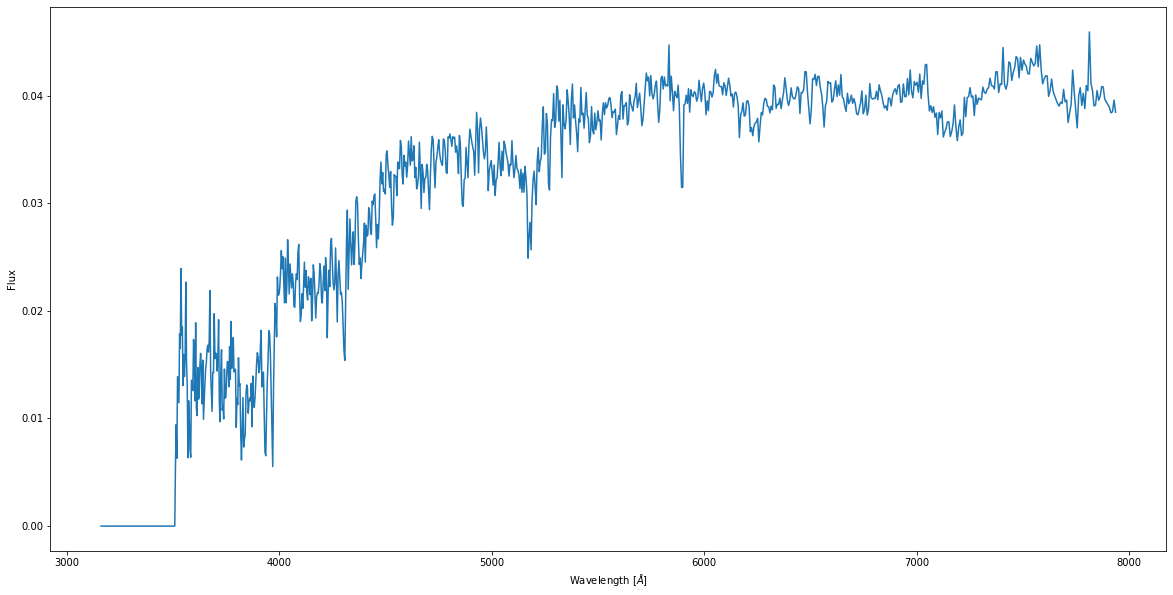

In [9]:
#%% Plot an example spectrum in the data
plt.figure(figsize=(20,10))
plt.plot(wavelengths,X_normal[4])
plt.xlabel('Wavelength [$\AA$]')
plt.ylabel('Flux')
plt.show()

In [10]:
#%% Set all zero normalised fluxes to nan
zero_norm_ind = X_normal == 0.
X_normal[zero_norm_ind] = np.NaN

In [11]:
#%% Transform errors due to corresponding normalisation
spec_err_T = np.transpose(spec_err)
spec_err_norm_T = np.divide(spec_err_T,norm)
spec_err_norm = np.transpose(spec_err_norm_T)

In [12]:
# %% Cap errors at a lower limit of 1e-5 times the flux
cap_counter = 0
for spectra in range(len(spec_err_norm)):
    for pixel in range(len(spec_err_norm[spectra])):
        if np.isnan(spec_err_norm[spectra][pixel]) == False and spec_err_norm[spectra][pixel] < 1e-5 * X_normal[spectra][pixel]:
            spec_err_norm[spectra][pixel] = 1e-5 * X_normal[spectra][pixel]
            cap_counter += 1
print("Number of capped errors", cap_counter)

Number of capped errors 27447


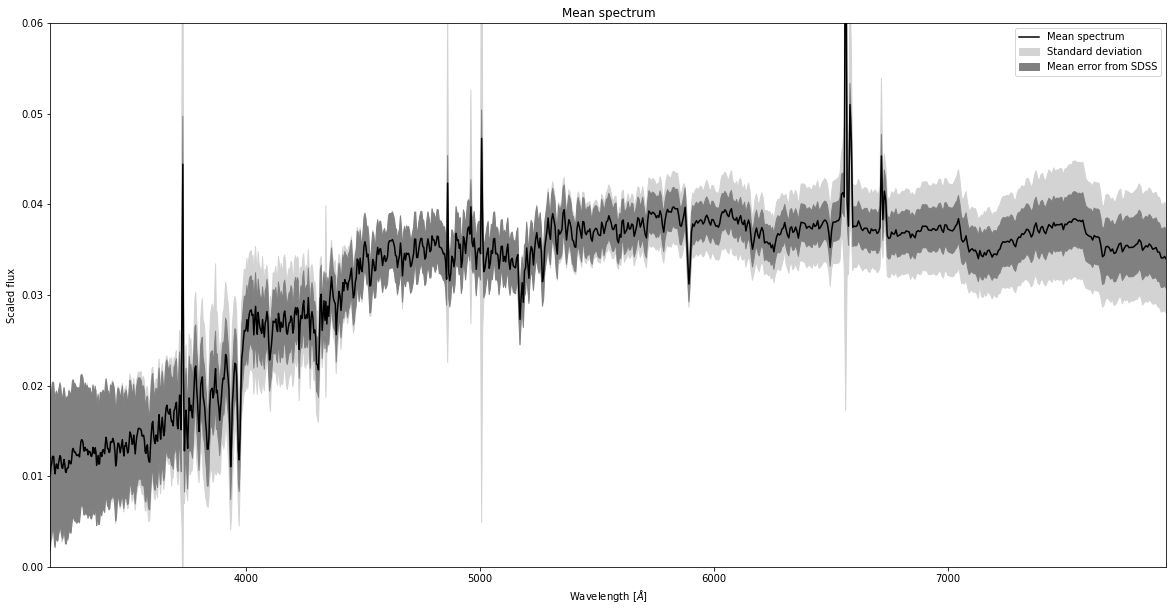

In [13]:
#%% Plot mean spectrum
mu = np.nanmean(X_normal, axis=0)
std = np.nanstd(X_normal, axis=0)
#mu = X_norm_zeros.mean(0)
#std = X_norm_zeros.std(0)
mean_err = np.nanmean(spec_err_norm, axis=0)
plt.figure(figsize=(20,10))
plt.plot(wavelengths, mu, color = 'black', label='Mean spectrum')
plt.fill_between(wavelengths, mu - std, mu + std , color = 'lightgrey', label='Standard deviation')
plt.fill_between(wavelengths, mu - mean_err, mu + mean_err , color = 'grey', label = 'Mean error from SDSS')
plt.xlim(wavelengths[0], wavelengths[-1])
plt.ylim(0,0.06)
plt.xlabel('Wavelength [$\AA$]')
plt.ylabel('Scaled flux')
plt.title('Mean spectrum')
plt.legend()
plt.show()

# 3. Apply PCA

In [14]:
pca = PCA(n_components=4, random_state=0)
X_red = pca.fit_transform(X_norm_zeros)

# 4. Plot the coefficients from X_red against each other

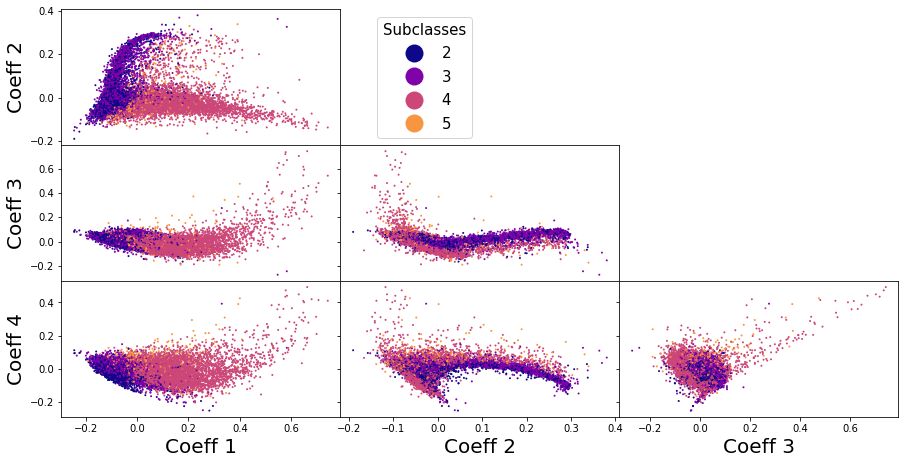

In [15]:
fig = plt.figure(figsize=(20,10))
gs = fig.add_gridspec(4, 4)
plt.rc('xtick',labelsize=10)
plt.rc('ytick',labelsize=10)
plt.set_cmap('plasma')

for i in np.arange(4):
    for j in np.arange(4):
        if i > j:
          ax = fig.add_subplot(gs[i,j])
          ax.label_outer()
          scatter1 = ax.scatter(X_red[:, j], X_red[:, i], c = subclass, s=4, lw=0, vmin=2, vmax=6)
          if i == 1 and j == 0:
            ax.legend(*scatter1.legend_elements(), bbox_to_anchor=(1.5, 1), title="Subclasses", fontsize=15, title_fontsize=15, markerscale=3)
          if i == 3:
            ax.set_xlabel(f'Coeff {j+1}', fontsize=20)
          if j == 0:
            ax.set_ylabel(f'Coeff {i+1}', fontsize=20)
plt.subplots_adjust(hspace=.0, wspace=.0)

plt.show()

# 5. Plot the mean spectrum and the first four eigenvectors of the spectral data

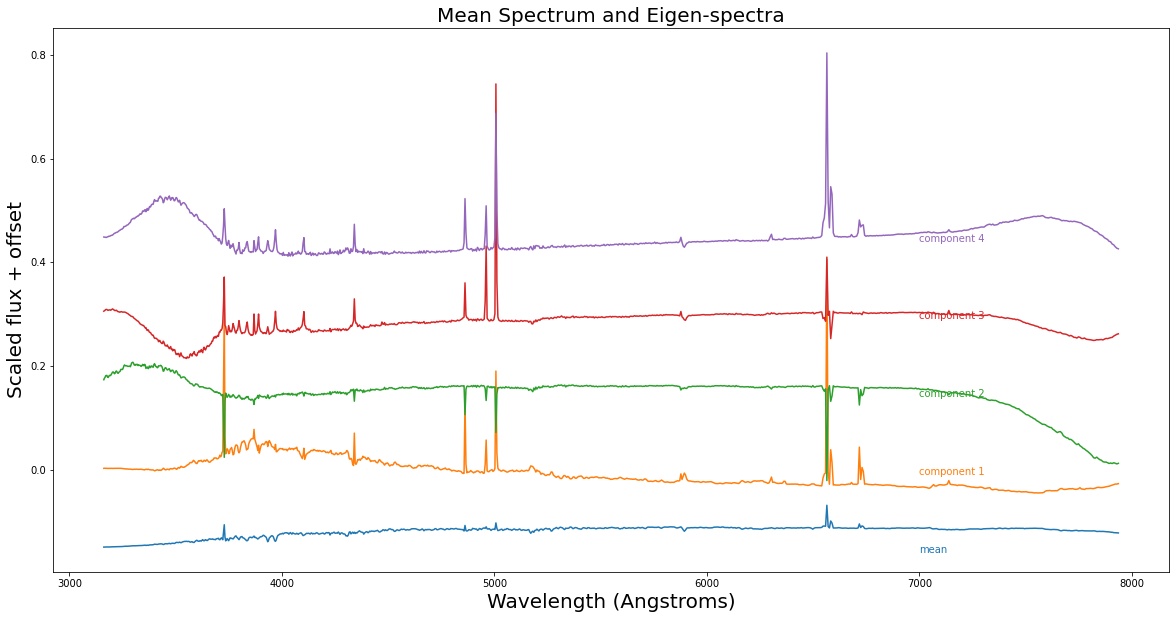

In [16]:
plt.figure(figsize=(20,10))
l = plt.plot(wavelengths, pca.mean_ - 0.15)
c = l[0].get_color()
plt.text(7000, -0.16, "mean", color=c)
for i in range(4):
    l = plt.plot(wavelengths, pca.components_[i] + 0.15 * i)
    c = l[0].get_color()
    plt.text(7000, -0.01 + 0.15 * i, "component %i" % (i + 1), color=c)
#plt.ylim(-0.2, 0.6)
plt.xlabel('Wavelength (Angstroms)', fontsize=20)
plt.ylabel('Scaled flux + offset', fontsize=20)
plt.title('Mean Spectrum and Eigen-spectra', fontsize=20)
plt.show()

# 6. Plot variance explained by each component

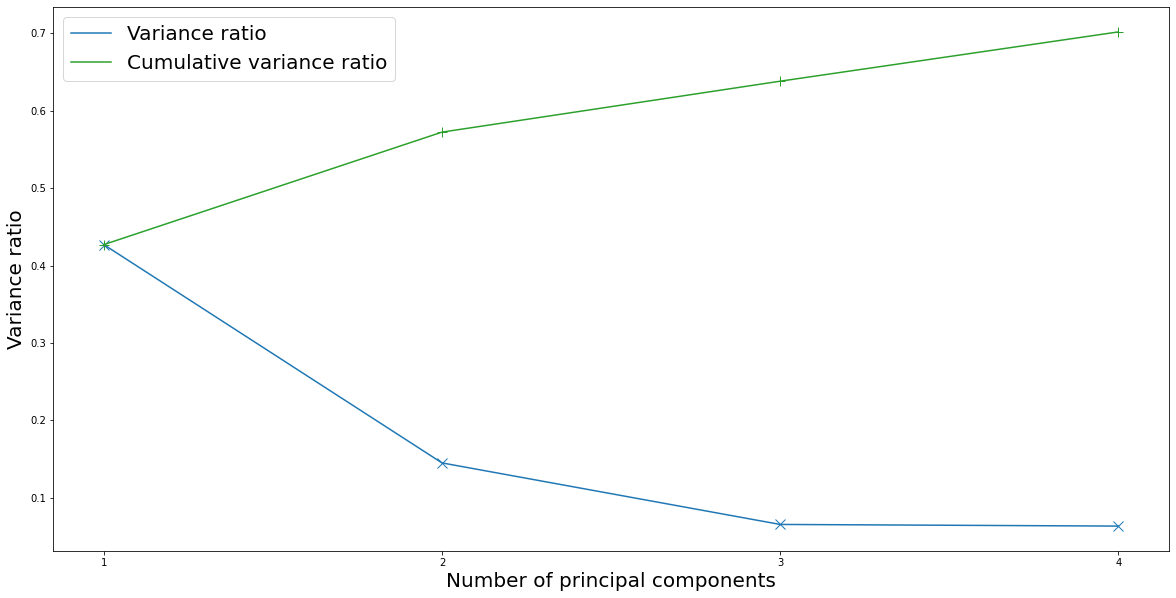

In [17]:
var = pca.explained_variance_ratio_
cum_var = np.cumsum(var)
plt.figure(figsize=(20,10))
plt.plot(np.array(range(1,pca.n_components_+1)), var, 'x', color='tab:blue', markersize=10)
plt.plot(np.array(range(1,pca.n_components_+1)), var, color='tab:blue', label='Variance ratio')
plt.plot(np.array(range(1,pca.n_components_+1)), cum_var, '+', color='tab:green', markersize=10)
plt.plot(np.array(range(1,pca.n_components_+1)), cum_var, color='tab:green', label='Cumulative variance ratio')
plt.xlabel('Number of principal components',fontsize=20)
plt.ylabel('Variance ratio',fontsize=20)
plt.xticks(np.array(range(1,pca.n_components_+1)))
plt.legend(fontsize=20)
plt.show()

# 7. Reconstruct an individual spectra

In [19]:
# %% Define function for plotting individual spectra
def reconstruct_spectra(spectra_num, components=None,plot_fig=True, plot_all=False):
    '''
    Returns reconstruction of a spectrum using the total number of components in the reduced dataset and plots the reconstructed
    spectrum and the original spectrum on the same figure.
    
    Input:
    spectra_num: Index of desired spectrum
    components: Number of components from reduced dataset to use in reconstruction. Default is 4
    plot_fig: If plot_fig=True, a plot of the reconstruction and the original spectrum will be shown, with subplots showing an
              increasing number of components used in the reconstruction
    plot_all: If plot_all=True, subplots showing the reconstruction with each additional component will be plotted. Otherwise only
              the final reconstruction with all PCA components is plotted. Default is plot_all=False
    
    Returns: 1D array of the reconstructed spectrum 
    '''
    if components == None:
        components = pca.components_.shape[0]
    #coeff = np.dot(pca.components_, X_norm_zeros[spectra_num] - pca.mean_)
    if plot_fig == True:
        fig = plt.figure(figsize=(20,10))
        if plot_all == True:
            for i, n in enumerate(range(components+1)):
                ax = fig.add_subplot(511 + i)
                ax.plot(wavelengths, X_norm_zeros[spectra_num], '-', c='gray', label='Original')
                ax.plot(wavelengths, pca.mean_ + np.dot(X_red[spectra_num][:n], pca.components_[:n]), '-k', label='Reconstruction')
            
                if i < 3:
                    ax.xaxis.set_major_formatter(plt.NullFormatter())
            
                ax.set_ylabel('Flux', fontsize=20)
            
                if n == 0:
                    text = "mean"
                elif n == 1:
                    text = "mean + 1 component\n"
                    text += r"$(\sigma^2_{tot}$ ratio $= %.2f)$" % cum_var[n - 1]
                else:
                    text = "mean + %i components\n" % n
                    text += r"$(\sigma^2_{tot}$ ratio $= %.2f)$" % cum_var[n - 1]
            
                ax.text(0.02, 0.93, text, ha='left', va='top', transform=ax.transAxes)
                plt.suptitle(f'Reconstruction of Spectra {spectra_num} (lineindex_cln=={subclass[spectra_num]})', fontsize=20)

        else:
            plt.plot(wavelengths, X_norm_zeros[spectra_num], '-', c='gray', label='Original')
            plt.plot(wavelengths, pca.mean_ + np.dot(X_red[spectra_num][:components], pca.components_[:components]), '-k', label='Reconstruction')     
            plt.ylabel('Flux', fontsize=20)
            plt.xlabel(r'${\rm wavelength\ (\AA)}$', fontsize=20)
            plt.title(f'Reconstruction of Spectra {spectra_num} (lineindex_cln=={subclass[spectra_num]})', fontsize=20)
            plt.legend(fontsize=20)
        plt.show()
 
    return pca.mean_ + np.dot(X_red[spectra_num][:components], pca.components_[:components])

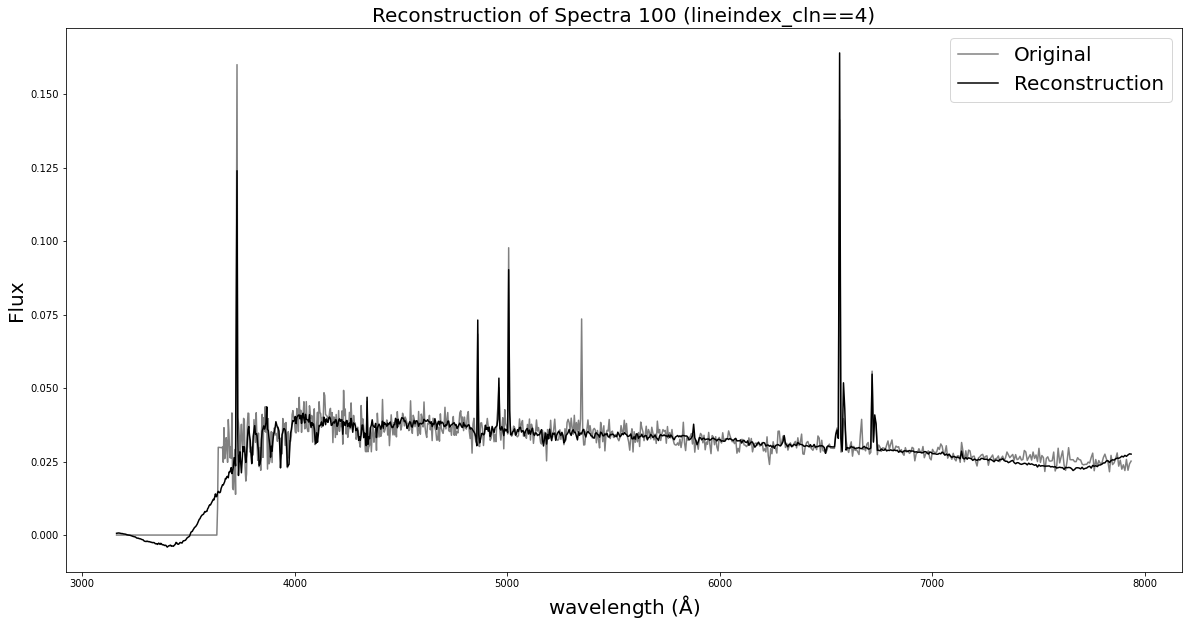

In [20]:
# Plot a spectrum
spectra_num = 100
_ = reconstruct_spectra(spectra_num)

# 8. Find $\chi^2$ test statistics for all 14672 spectra and plot histogram

In [22]:
def calculate_allchi(original, mean, coeffs, components, noise):
  chi_arr = np.zeros(original.shape[1])
  for spec_num in range(len(original)):
    reconstruction = mean + np.dot(coeffs[spec_num], components)
    chi = ((reconstruction - original[spec_num]) / noise[spec_num]) ** 2
    chi_arr = np.vstack((chi_arr, chi))
  chi_arr = np.delete(chi_arr, 0, 0)
  #chi_arr[chi_arr == 0.] = np.nan

  return chi_arr

In [23]:
chi_arr = calculate_allchi(X_norm_zeros, pca.mean_, X_red, pca.components_, spec_err_norm)
num_validpix_per_pixel = np.count_nonzero(~np.isnan(chi_arr), axis=0)
num_validpix_per_spectra = np.count_nonzero(~np.isnan(chi_arr), axis=1)
chi_per_spectra = np.nansum(chi_arr, axis=1)/np.count_nonzero(~np.isnan(chi_arr), axis=1)
chi_per_pixel_mean = np.nanmean(chi_arr ** 0.5, axis=0)
chi_per_pixel_var= np.nanvar(chi_arr ** 0.5, axis=0)

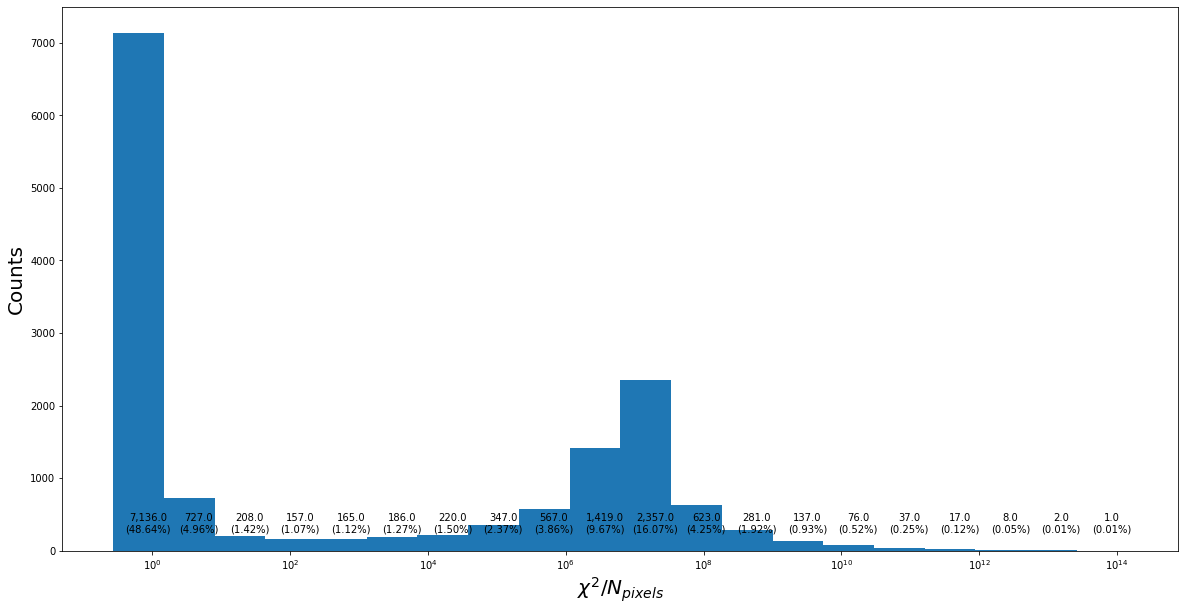

In [24]:
# %% Plot chi-squared values
# Code adapted from https://towardsdatascience.com/advanced-histogram-using-python-bceae288e715
fig, ax = plt.subplots(figsize=(20,10))
_, bins = np.histogram(chi_per_spectra, bins=20)

# Plot histogram on log scale
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
logcounts, _, _ = ax.hist(chi_per_spectra, bins=logbins)
ax.set_xscale('log')
        
# Calculate bar centre to display the count of data points and %
bin_x_centers = 0.5 * np.diff(logbins) + logbins[:-1]
bin_y_centers = ax.get_yticks()[1] * 0.25

# Display the the count of data points and % for each bar in histogram
for i in range(len(bins)-1):
    bin_label = "{0:,}".format(logcounts[i]) + "\n({0:,.2f}%)".format((logcounts[i]/logcounts.sum())*100)    
    ax.text(bin_x_centers[i], bin_y_centers, bin_label, horizontalalignment='center')    

plt.xlabel("$\chi^2/N_{pixels}$", fontsize=20)
plt.ylabel('Counts',fontsize=20)
plt.show()

# 9. Store all reconstructed spectrums in Astropy Table along with original spectrums

In [25]:
# %% Make an Astropy Table to store reconstruction data
reconstruction_arr = np.zeros(X_norm_zeros.shape)
for i in range(len(X_norm_zeros)):
    reconstruction_arr[i] = reconstruct_spectra(i, plot_fig=False)

reconstruction_table = Table([np.arange(len(X_norm_zeros)), subclass, X_norm_zeros, reconstruction_arr, chi_per_spectra, num_validpix_per_spectra],
                                        names=('index', 'subclass', 'original', 'reconstruction', 'chi_squared_stat', 'N_pixels_chi'),)

reconstruction_table[:5]

index,subclass,original [1000],reconstruction [1000],chi_squared_stat,N_pixels_chi
int64,int32,float32,float64,float64,int64
0,2,0.0 .. 0.03756418,-0.00039142195601016283 .. 0.035835474729537964,0.6012326279921304,886
1,3,0.0 .. 0.0,0.005420329049229622 .. 0.00012136809527873993,4563155.947292318,958
2,3,0.0 .. 0.03961591,-0.0007354310946539044 .. 0.03755389153957367,1.2337911477467516,886
3,4,0.0 .. 0.0348151,-0.00042068189941346645 .. 0.0342322513461113,0.3806770566939462,895
4,2,0.0 .. 0.038455404,-0.0007010025437921286 .. 0.03731127083301544,0.503522562384785,886


# 10. Filter reconstructions by subclass and plot histograms of $\chi^2$ values for each subclass

In [26]:
# %% Filter reconstructions by subclass
absorption = reconstruction_table[reconstruction_table['subclass']==2]
normal = reconstruction_table[reconstruction_table['subclass']==3]
emission = reconstruction_table[reconstruction_table['subclass']==4]
narrow_qso = reconstruction_table[reconstruction_table['subclass']==5]

2: Absorption galaxy 6821 (chi-squared stat:1580.6710816120342)


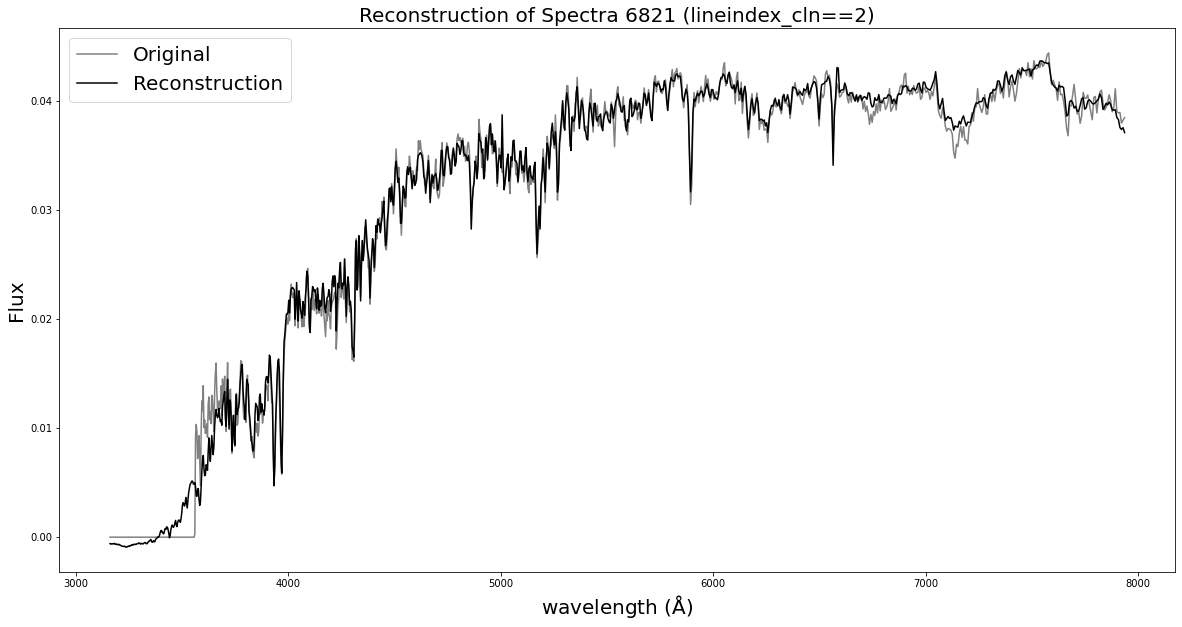

3: Normal galaxy 7346 (chi-squared stat:14.345933670478606)


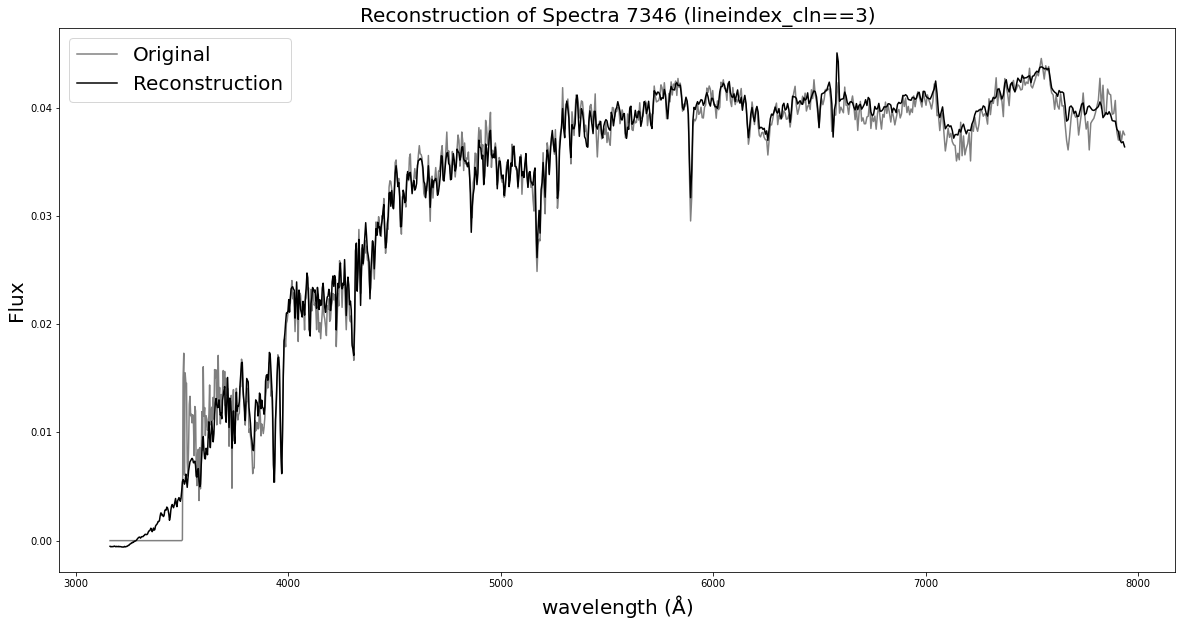

4: Emission galaxy 1524 (chi-squared stat:0.7924623839716971)


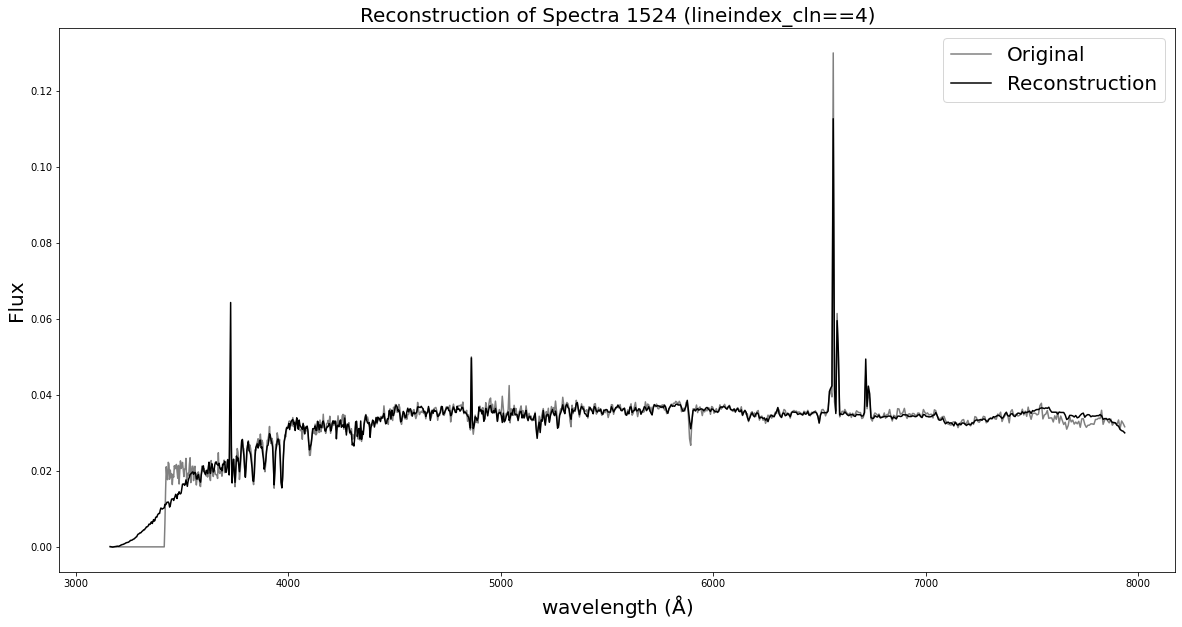

5: Narrow line QSO 9897 (chi-squared stat:0.39438908702590186)


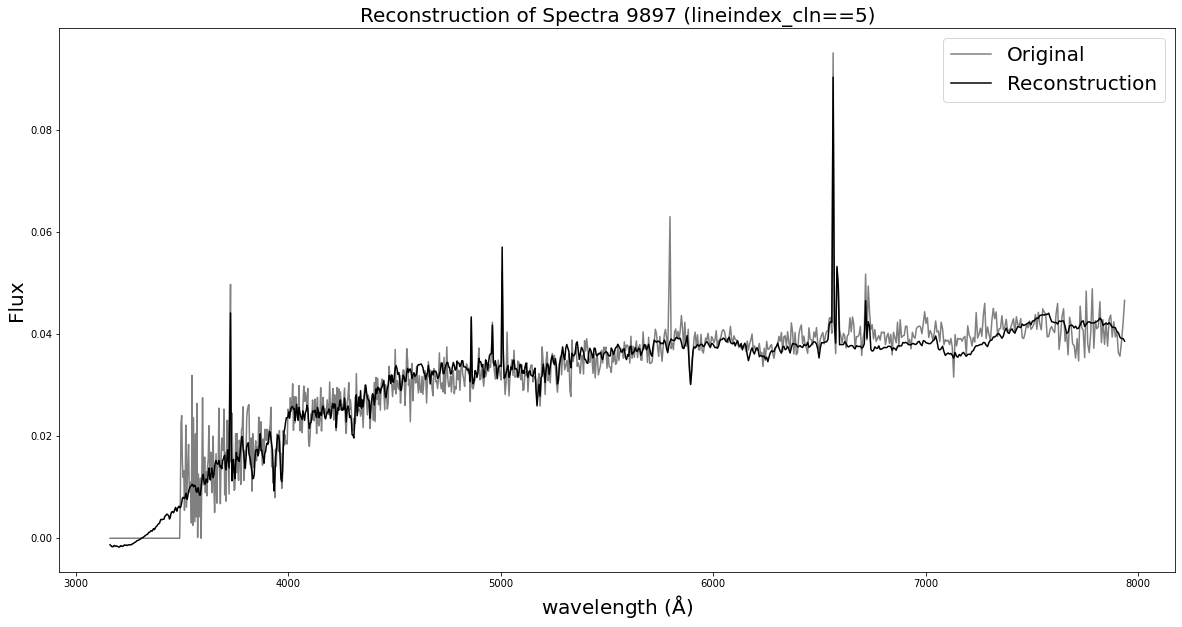

In [27]:
# %% Plot reconstruction for one example from each subclass
randnum = np.random.choice(absorption['index'])
print(f"2: Absorption galaxy {randnum} (chi-squared stat:{chi_per_spectra[randnum]})")
_ = reconstruct_spectra(randnum)

randnum = np.random.choice(normal['index'])
print(f"3: Normal galaxy {randnum} (chi-squared stat:{chi_per_spectra[randnum]})")
_ = reconstruct_spectra(randnum)

randnum = np.random.choice(emission['index'])
print(f"4: Emission galaxy {randnum} (chi-squared stat:{chi_per_spectra[randnum]})")
_ = reconstruct_spectra(randnum)

randnum = np.random.choice(narrow_qso['index'])
print(f"5: Narrow line QSO {randnum} (chi-squared stat:{chi_per_spectra[randnum]})")
_ = reconstruct_spectra(randnum)

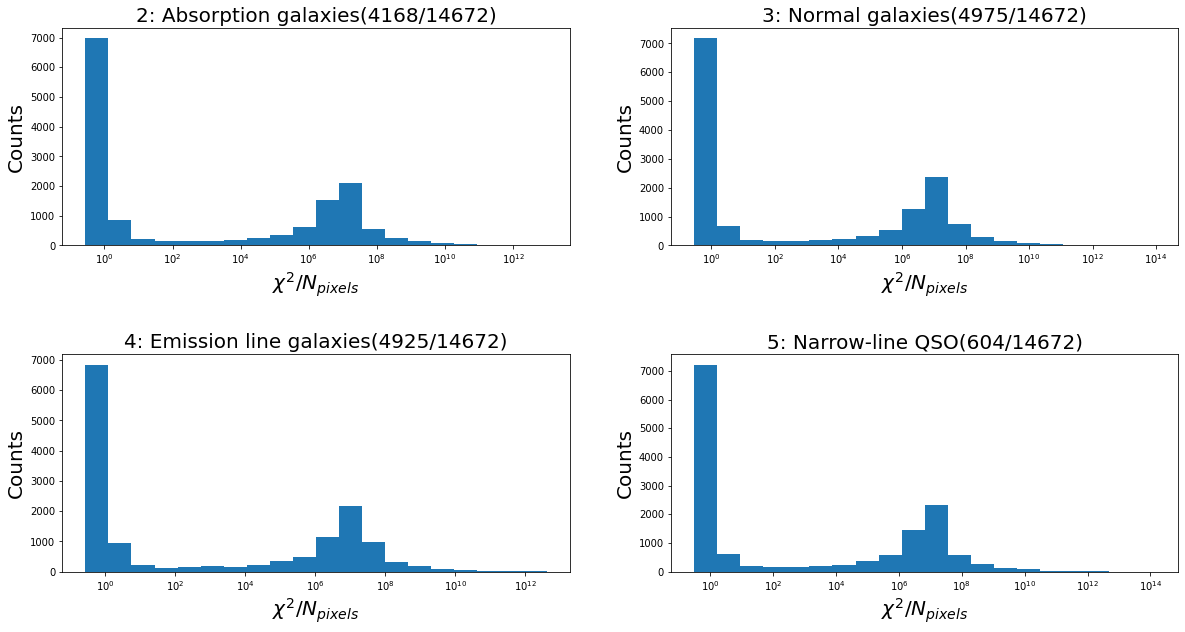

In [28]:
# %% Plot chi-squared value histograms for each subclass
plt.figure(figsize=(20,10))
subclass_names = ['2: Absorption galaxies', '3: Normal galaxies', '4: Emission line galaxies', '5: Narrow-line QSO']
for i in range(4):
    ax = plt.subplot(221 + i)
    _, bins = np.histogram(chi_per_spectra[subclass==i+2], bins=20)
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    logcounts, _, _ = ax.hist(chi_per_spectra, bins=logbins)
    ax.set_xscale('log')
    bin_x_centers = 0.5 * np.diff(logbins) + logbins[:-1]
    bin_y_centers = ax.get_yticks()[1] * 0.25 
#    for j in range(len(bins)-1):
#        bin_label = "{0:,}".format(logcounts[j]) + "\n({0:,.2f}%)".format((logcounts[j]/logcounts.sum())*100)    
#        ax.text(bin_x_centers[j], bin_y_centers, bin_label, horizontalalignment='center')
    ax.set_xlabel("$\chi^2/N_{pixels}$", fontsize=20)
    ax.set_ylabel('Counts',fontsize=20)
    ax.set_title(f'{subclass_names[i]}({len(chi_arr[subclass==i+2])}/{len(subclass)})', fontsize=20)
plt.subplots_adjust(hspace=.5, wspace=.2)
plt.show()

# 11. Caculate residual for each pixel number across all spectra

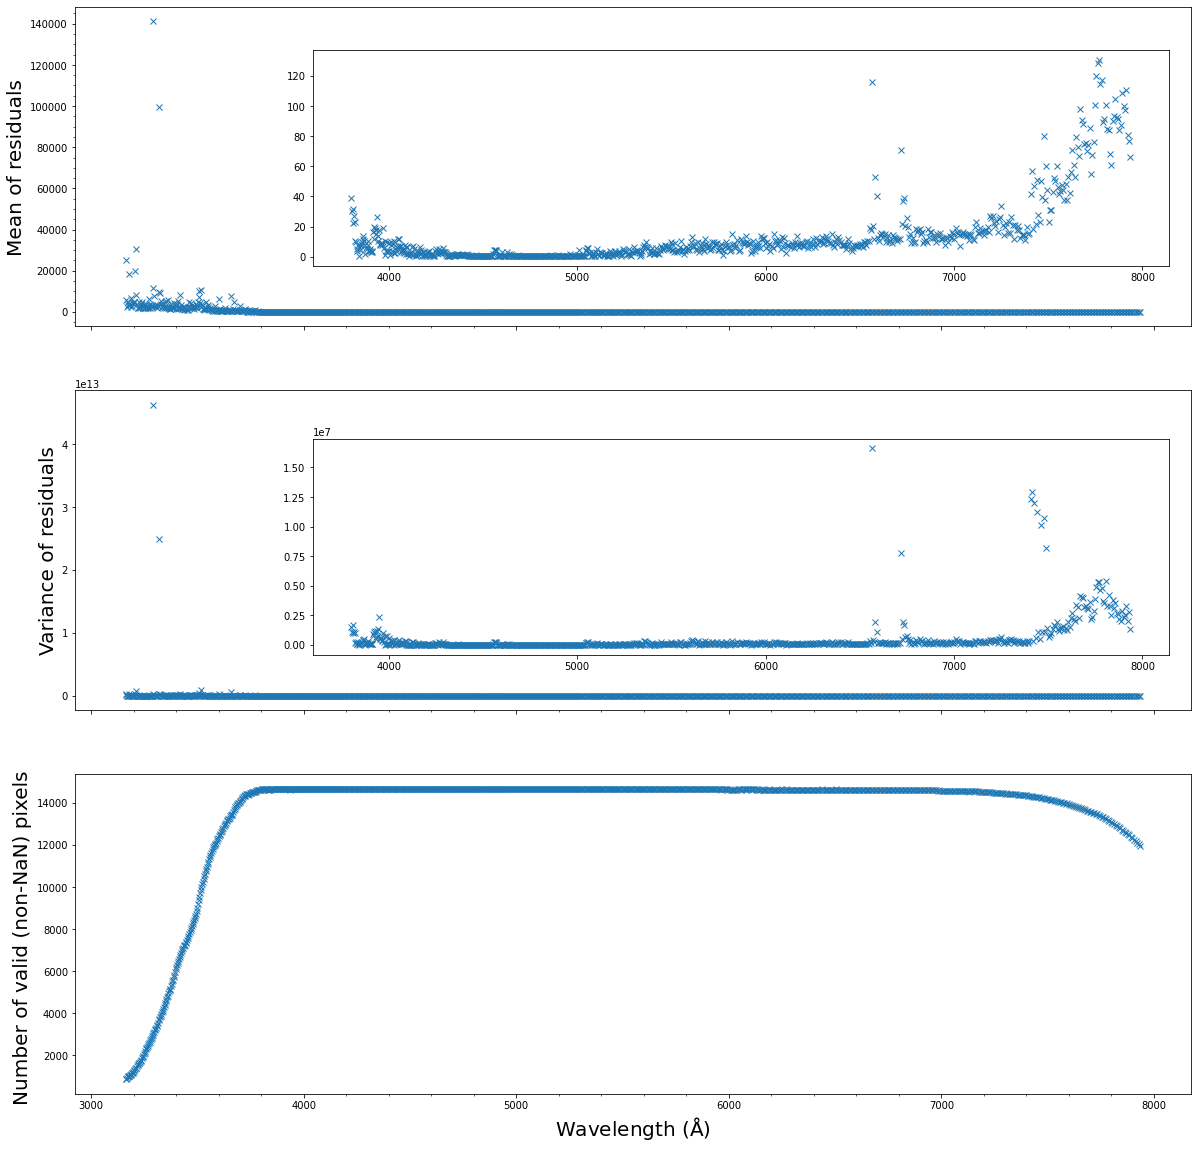

In [29]:
# %% Plot mean and variance of residuals, and number of valid pixels used
end_num = 200
fig, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True, figsize=(20,20))

ax1.plot(wavelengths, chi_per_pixel_mean,'x')
ax1.minorticks_on()
axins1 = fig.add_axes([0.29, 0.7, 0.595, 0.15])
#axins1.plot(range(end_num,len(chi_means)),chi_means[end_num:], 'x')
axins1.plot(wavelengths[200:],chi_per_pixel_mean[end_num:], 'x')
ax1.set_ylabel("Mean of residuals", fontsize=20)

ax2.plot(wavelengths, chi_per_pixel_var,'x')
axins2 = fig.add_axes([0.29, 0.43, 0.595, 0.15])
#axins2.plot(range(end_num,len(chi_vars)),chi_vars[end_num:], 'x')
axins2.plot(wavelengths[200:], chi_per_pixel_var[end_num:], 'x')
ax2.set_ylabel("Variance of residuals", fontsize=20)

ax3.plot(wavelengths, num_validpix_per_pixel, 'x')
ax3.set_ylabel("Number of valid (non-NaN) pixels ", fontsize=20)
ax3.set_xlabel(r'${\rm Wavelength\ (\AA)}$', fontsize=20)
plt.show()